In [1]:
DATA_PATH = "../Dataset/Processed/adultProcessed.csv"

### Import Helper Library

In [57]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler , PolynomialFeatures , OneHotEncoder ,OrdinalEncoder ,MinMaxScaler ,RobustScaler
import category_encoders as ce
from category_encoders import BinaryEncoder
from sklearn.impute import KNNImputer , SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB ,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier , GradientBoostingClassifier ,ExtraTreesClassifier ,VotingClassifier
from xgboost import XGBClassifier


from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score , f1_score , recall_score , precision_score , confusion_matrix , ConfusionMatrixDisplay ,fbeta_score
from sklearn.model_selection import cross_validate , GridSearchCV ,StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel

from imblearn.pipeline import make_pipeline , Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek ,SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import traceback
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_pickle(DATA_PATH)
df.shape

(29892, 12)

In [69]:
df = df[df["income"] == 1]

In [71]:
df

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income,net_capital
7,52,Self-emp-not-inc,HS-grad,Married,Exec-managerial,Husband,White,Male,45,United-States,1,Low
8,31,Private,Masters,Single,Prof-specialty,Not-in-family,White,Female,50,United-States,1,High
9,42,Private,Bachelors,Married,Exec-managerial,Husband,White,Male,40,United-States,1,High
10,37,Private,Some-college,Married,Exec-managerial,Husband,Black,Male,80,United-States,1,Low
11,30,State-gov,Bachelors,Married,Prof-specialty,Husband,Others,Male,40,Non-United-States,1,Low
...,...,...,...,...,...,...,...,...,...,...,...,...
29872,38,Private,Bachelors,Single,Prof-specialty,Unmarried,Black,Female,45,United-States,1,High
29876,39,Local-gov,Assoc-acdm,Married,Adm-clerical,Wife,White,Female,20,United-States,1,Low
29885,53,Private,Masters,Married,Exec-managerial,Husband,White,Male,40,United-States,1,Low
29888,40,Private,HS-grad,Married,Machine-op-inspct,Husband,White,Male,40,United-States,1,Low


In [76]:
df.relationship.unique()

array(['Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative',
       'Own-child'], dtype=object)

In [5]:
for col in df.select_dtypes('object').columns :
    
    print(f'{col} -- {df[col].nunique()}')

workclass -- 7
education -- 16
marital_status -- 2
occupation -- 14
relationship -- 6
race -- 3
sex -- 2
native_country -- 2
net_capital -- 2


In [6]:
df.income.value_counts()

income
0    22408
1     7484
Name: count, dtype: int64

In [7]:
X = df.drop(columns=["income"])
y = df["income"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=101, stratify=y
)

In [9]:
df.select_dtypes('number').columns

Index(['age', 'hours_per_week', 'income'], dtype='object')

In [10]:
df.select_dtypes('object').columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'net_capital'],
      dtype='object')

In [11]:
numeric_features = ["age", "hours_per_week"]
cat_binary_features = ["education", "occupation" ,"workclass" ]
cat_onehot_features = ["sex", "race" , "relationship" ,"native_country" , "net_capital" , "marital_status"] 

In [12]:
numeric_pipe = Pipeline([
    ("scaler", StandardScaler())
])

In [13]:
cat_binary_pipe = Pipeline([
    ("binenc", ce.BinaryEncoder(handle_unknown="ignore")),
    ("scaler", StandardScaler())
])

In [14]:
cat_onehot_pipe = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ("scaler", StandardScaler())
])

In [15]:
preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_features),
    ("bin_cat", cat_binary_pipe, cat_binary_features),
    ("oh_cat", cat_onehot_pipe, cat_onehot_features),
])

In [16]:
models = []
models.append(('LR' , LogisticRegression(max_iter=1000)))
models.append(('KNNC' , KNeighborsClassifier()))
models.append(('SVC' , SVC()))
models.append(('BNB', BernoulliNB()))
models.append(('DTC' , DecisionTreeClassifier()))
models.append(('EXT', ExtraTreesClassifier()))
models.append(('RFC' , RandomForestClassifier()))
models.append(('ADB', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB' , XGBClassifier()))     
models.append(('NB' , GaussianNB()))


In [17]:
scoring = ['accuracy' , 'recall' , 'f1' , 'precision']

In [18]:
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
sm = SMOTE(sampling_strategy={1 : 7000})
rm = RandomUnderSampler(sampling_strategy={0 : 13000})

In [19]:
results = []

In [20]:
for model in models: 

    model_name, estimator = model 

    post_scaler = MinMaxScaler() if model_name in {"BNB", "GNB", "NB"} else StandardScaler() 

    PL = make_pipeline( preprocess, smt, post_scaler, SelectFromModel(estimator=RandomForestClassifier(random_state=42)), estimator )

    scores = cross_validate( estimator=PL, X=X, y=y, cv=5, scoring=scoring, return_train_score=True, n_jobs=-1 )
    
    print('-'*60) 
    print(model_name) 

    print(f"train accuracy : {scores['train_accuracy'].mean():.4f} , test accuracy : {scores['test_accuracy'].mean():.4f}") 
    print(f"train recall : {scores['train_recall'].mean():.4f} , test recall : {scores['test_recall'].mean():.4f}") 
    print(f"train precision : {scores['train_precision'].mean():.4f} , test precision : {scores['test_precision'].mean():.4f}") 
    print(f"train f1_score : {scores['train_f1'].mean():.4f} , test f1_score : {scores['test_f1'].mean():.4f}") 
    
    results.append((model_name, scores))

------------------------------------------------------------
LR
train accuracy : 0.7662 , test accuracy : 0.7653
train recall : 0.8078 , test recall : 0.8060
train precision : 0.5218 , test precision : 0.5205
train f1_score : 0.6338 , test f1_score : 0.6323
------------------------------------------------------------
KNNC
train accuracy : 0.8097 , test accuracy : 0.7764
train recall : 0.6550 , test recall : 0.6048
train precision : 0.6124 , test precision : 0.5489
train f1_score : 0.6329 , test f1_score : 0.5754
------------------------------------------------------------
SVC
train accuracy : 0.7612 , test accuracy : 0.7604
train recall : 0.8505 , test recall : 0.8502
train precision : 0.5140 , test precision : 0.5131
train f1_score : 0.6408 , test f1_score : 0.6399
------------------------------------------------------------
BNB
train accuracy : 0.7062 , test accuracy : 0.7052
train recall : 0.8384 , test recall : 0.8375
train precision : 0.4532 , test precision : 0.4522
train f1_scor

In [ ]:
pipe_XGB = Pipeline([
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(include_bias=False)), 
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=42 
    ))
])

In [22]:
param_grid_xgb = {
    "xgb__n_estimators": [100, 200, 400],
    "xgb__max_depth": [3, 6, 10],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "xgb__subsample": [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "poly__degree": [0, 1] 
}

In [23]:
grid_search = GridSearchCV(
    estimator=pipe_XGB,
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
    scoring='f1',
    n_jobs=1, 
    verbose=2,
    return_train_score=True
)

In [24]:
grid_search.fit(X, y)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.6; total time=   0.0s
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.6; total time=   0.0s
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.6; total time=   0.0s
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END poly__degree=0, xgb__colsample_bytree=0.6, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=  

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'poly__degree': [0, 1], 'xgb__colsample_bytree': [0.6, 0.8, ...], 'xgb__learning_rate': [0.01, 0.05, ...], 'xgb__max_depth': [3, 6, ...], ...}"
,scoring,'f1'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('num', ...), ('bin_cat', ...), ...]"


In [39]:
print("Best params:", grid_search.best_params_)
print("Best CV f1:", grid_search.best_score_)

Best params: {'poly__degree': 1, 'xgb__colsample_bytree': 0.6, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 6, 'xgb__n_estimators': 400, 'xgb__subsample': 0.8}
Best CV f1: 0.6734518017267765


In [32]:
print("Best estimator:",grid_search.best_estimator_)

Best estimator: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'hours_per_week']),
                                                 ('bin_cat',
                                                  Pipeline(steps=[('binenc',
                                                                   BinaryEncoder(handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['education', 'occupation',
                                                   'workclass']),
                                                 ('oh_cat',
                                      

In [ ]:
best = grid_search.best_estimator_

In [ ]:
y_test_pred = best.predict(X_test)
y_train_pred = best.predict(X_train)

In [55]:
print(f"Train accuracy : {accuracy_score(y_train, y_train_pred):.4f} ,  Test accuracy : {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Train precision: {precision_score(y_train, y_train_pred):.4f} ,  Test precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Train recall   : {recall_score(y_train, y_train_pred):.4f} ,  Test recall   : {recall_score(y_test, y_test_pred):.4f}")
print(f"Train f1       : {f1_score(y_train, y_train_pred):.4f} ,  Test f1       : {f1_score(y_test, y_test_pred):.4f}")


Train accuracy : 0.8720 ,  Test accuracy : 0.8709
Train precision: 0.7865 ,  Test precision: 0.7916
Train recall   : 0.6711 ,  Test recall   : 0.6573
Train f1       : 0.7242 ,  Test f1       : 0.7182


In [56]:
y_pred = cross_val_predict(best, X, y, cv=5)  

<Figure size 800x600 with 0 Axes>

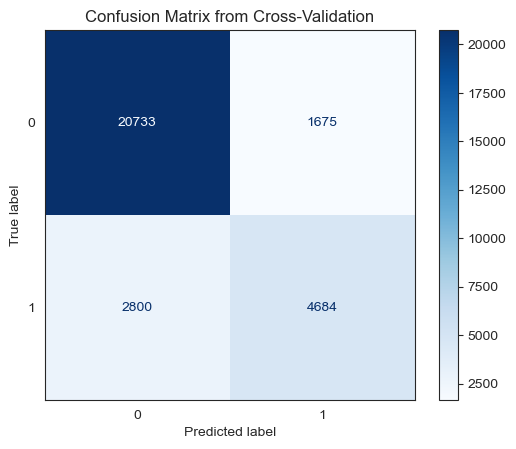

In [64]:
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.set_style('white')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix from Cross-Validation')
plt.show()

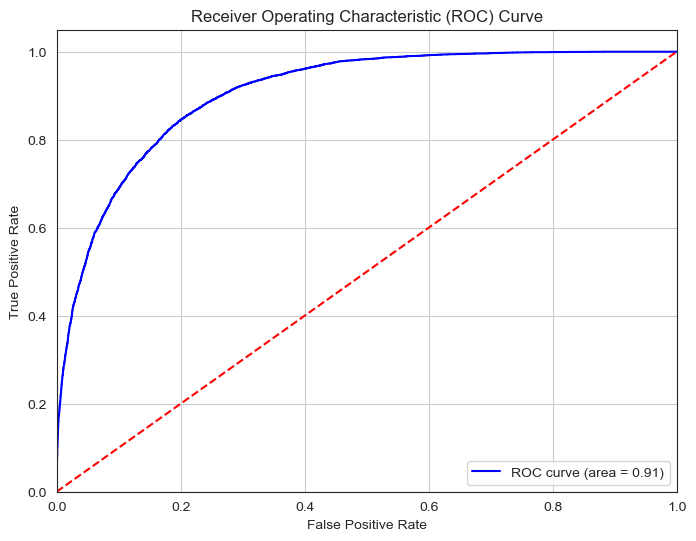

In [59]:
y_scores = cross_val_predict(best, X, y, cv=5, method='predict_proba')[:, 1]


fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [60]:
import pickle

In [61]:
with open('xgboost_model.pkl', 'wb') as model_file:
    pickle.dump(best, model_file)